# HiRISE Thumbnails Modeling

In this notebook, I train a convolutional neural network on a stack of about ~70,000 thumbnail images of interesting places on the surface of Mars. These images were scraped off the [HiRISE catolog](https://www.uahirise.org/catalog/) using scripts in the [repository](https://github.com/markmbaum/hirise-thumbnails/tree/main/scripts) and cleaned up a bit in [another notebook](https://github.com/markmbaum/hirise-thumbnails/blob/main/hirise_thumbnails_prep.ipynb). The original images are much, much larger than these thumbnail sized versions, which are no larger than a couple hundred pixels and have been cropped to a uniform 150 x 100 pixels here.

Some basic metadata for each image was also scraped off of the catalog. The metadata include quantities like the solar longitude (season), the local time, and the solar azimuth at the time each image was taken. There are also title strings for each image. I attempted to use these title strings to produce classification labels in [the other notebook](https://github.com/markmbaum/hirise-thumbnails/blob/main/hirise_thumbnails_prep.ipynb), but they don't make for good labels.

**In this notebook, I attempt to train a model that can predict the [solar azimuth](https://www.uahirise.org/faq/) for these images,** which is a single continuous parameter. The solar azimuth is the angle formed between the sun and the surface normal vector, between 0 and 90 degrees. When the sun is directly overhead, the angle is zero.

The idea is that a convolutional neural network might be able to learn the solar azimuth from the relationships between topographic features in the images and their shadows. This is a challenging task because the images are very diverse and irregular. On Earth, this would be even more challenging. The Earth's surface is more complex, potentially covered in vegetation, and you have to worry about clouds and their shadows. Mars has neither.

I use grayscale for all the images. The color channels are [somewhat artificial](https://www.uahirise.org/pdf/color-products.pdf), including frequencies outside the usual visible window tuned to maximuze the contrast between different materials. As such, the colors are inconsistent, using grayscale is probably better, and it's a little more efficient. A good example of the non-visible coloring is [ESP_073613_2210](https://www.uahirise.org/ESP_073613_2210).

As is shown below, the model mostly fails to accurately predict solar azimuth. It is only able to learn a small percentage of the variance in this quantity. This wasn't particularly suprising. Many images scarcely have any shadows. By the time I tried this task, I had also already tried using autoencoders and generative adversarial networks to learn features of the image stack without supervision, but both of those attempts also mostly failed. More sophisticated models might succeed, and more generally I think surface imagery and remote sensing data are intersting and challenging modeling targets, but these martian images are complex and difficult to extract features from. Poor results, but a good little project to learn about image learning.

This notebook was executed with GPU runtime on Google Colab.

In [1]:
import numpy as np
from numpy import *
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# Load and Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#load images
images = np.load('drive/MyDrive/data/hirise-thumbnails/hirise_thumbnails.npy')
images.shape

(71968, 100, 150, 3)

In [5]:
#convert to grayscale in [0,1]
images = images.mean(axis=3).astype(float32)/255
images.shape

(71968, 100, 150)

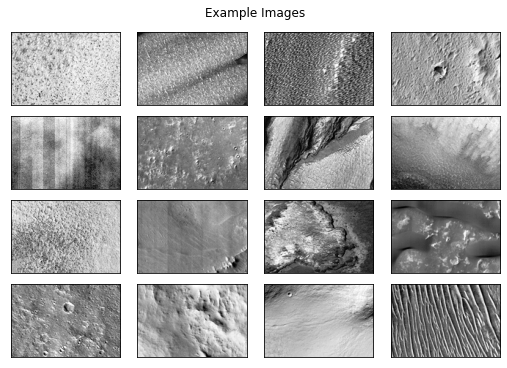

In [6]:
#plot a sample of images
fig, axs = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow(images[i,...], cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Example Images');

In [7]:
#load metadata
df = read_csv('drive/MyDrive/data/hirise-thumbnails/hirise_metadata.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71968 entries, ESP_067230_1115 to ESP_017324_1795
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Acquisition date            71968 non-null  object 
 1   Local Mars time             71968 non-null  object 
 2   Latitude (centered)         71968 non-null  float64
 3   Longitude (East)            71968 non-null  float64
 4   Spacecraft altitude         71968 non-null  object 
 5   Original image scale range  71968 non-null  object 
 6   Map projected scale         71968 non-null  object 
 7   Map projection              71968 non-null  object 
 8   Emission angle              71968 non-null  float64
 9   Phase angle                 71968 non-null  float64
 10  Solar incidence angle       71968 non-null  object 
 11  Solar longitude             71968 non-null  object 
 12  North azimuth               71968 non-null  int64  
 13  Sub-solar az

In [8]:
L = len(df)
print(images.shape, L)

(71968, 100, 150) 71968


In [9]:
#rename columns of interest and drop the rest
df = DataFrame({
    'time': df['Local Mars time'],
    'lat': df['Latitude (centered)'],
    'solar_angle': df['Solar incidence angle'],
    'solar_lon': df['Solar longitude']
})

In [10]:
#check if a character is part of a number
isnumeric = lambda x: x.isnumeric() or x in '-.'
#convert a string to a number
tonumeric = lambda x: float(''.join(filter(isnumeric, x)))

In [11]:
#convert each column to a usable numeric format
for i in df.index:
    #time
    t = df.at[i,'time']
    hr, min = t.split(':')
    df.at[i,'time'] = float(hr)*60/1477 + float(min)/1477 # 1477 minutes in Mars day
    df.at[i,'time'] *= 2*pi #convert to a time-of-day phase angle
#latitude to radians
df.lat = df.lat.map(deg2rad)
#solar incidence angle
df.solar_angle = df.solar_angle.map(lambda x: tonumeric(x.split(',')[0]))
df.solar_angle = df.solar_angle.map(deg2rad)
#solar longitude (season)
df.solar_lon = df.solar_lon.map(tonumeric)
df.solar_lon = df.solar_lon.map(deg2rad)

print(df)

                     time       lat  solar_angle  solar_lon
ESP_067230_1115  3.803093 -1.190646     1.047198   5.630432
ESP_035891_2610  3.645694  1.414031     1.029744   1.858776
ESP_055244_1765  3.943475 -0.060074     0.907571   3.019420
ESP_035240_1975  3.858395  0.303356     0.767945   1.466077
ESP_055711_1965  3.956237  0.286042     0.977384   3.380703
...                   ...       ...          ...        ...
ESP_025716_2200  3.777568  0.691971     0.698132   1.045452
ESP_028244_2070  3.934967  0.469441     0.872665   2.621485
PSP_010018_2000  3.960491  0.348158     0.872665   2.223549
ESP_046439_1875  3.913697  0.128020     0.872665   3.028146
ESP_017324_1795  3.875411 -0.005044     0.907571   1.296780

[71968 rows x 4 columns]


In [12]:
#take only the solar azimuth column for training targets
targets = df.solar_angle.values.astype(float32)

In [13]:
#standardize and store the standardization
standard = (targets.mean(), targets.std())
targets -= targets.mean()
targets /= targets.std()

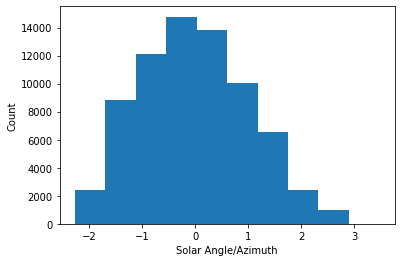

In [14]:
#check out the target distribution
plt.hist(targets)
plt.xlabel('Solar Angle/Azimuth')
plt.ylabel('Count');

In [15]:
images.shape, targets.shape

((71968, 100, 150), (71968,))

In [16]:
#training, validation, test splits
#   70         20       10  
n = images.shape[0]//10
ds = tf.data.Dataset.from_tensor_slices((images.reshape(L,100,150,1), targets))
ds = ds.shuffle(L)
train = ds.take(7*n).batch(64)
validate = ds.skip(7*n).take(2*n).batch(64)
test = ds.skip(9*n).batch(64)

# Model Construction and Training

In [17]:
#creates a stack of convolutional layers with pooling and dropout at the end
def conv_block(filters, kernel=3, padding='valid', layers=3, dropout=0.2):
    block = []
    for i in range(layers):
        block += [
            Conv2D(filters, kernel, padding=padding),
            BatchNormalization(),
            ReLU()
        ]
    block += [
        MaxPool2D(),
        Dropout(dropout)
    ]
    return block

The model consists of fairly typical convolutional, feed-forward architecture. Training images are scaled to [-1,1], randomly zoomed very slightly, and augmented with a small amount of noise. The model has three blocks of convolutional layers, each with three layers within it, and each with pooling and dropout at the end. There are 4 dense layers at the end. The convolutional layers are `relu` activated and the dense layers are `selu` activated. All told, there are 12 active layers.

In [18]:
model = Sequential([
    #rescale image to [-1,1]
    Rescaling(2, -1),
    #small amount of noise+augmentation
    RandomZoom((0,0.05), (0,0.05)),
    GaussianNoise(0.05)
])
#three convolutional blocks
for filters in (32, 64, 128):
    for layer in conv_block(filters):
        model.add(layer)
#final dense layers
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dense(128, activation='selu'))
model.add(Dense(16, activation='selu'))
model.add(Dense(1))

In [19]:
model.compile(
    optimizer=Adam(5e-4),
    loss='mse',
    metrics=[
        MeanAbsoluteError()
    ]
)

The model is trained with a callback that saves the state where the validation loss is minimized. The learning rate is also scheduled to decrease by a factor of 2 every epoch.

In [20]:
history = model.fit(
    train,
    epochs=8,
    validation_data=validate,
    callbacks=[
        EarlyStopping('val_loss', patience=1),
        LearningRateScheduler(lambda epoch, lr: lr*0.5),
        ModelCheckpoint(
            './model-checkpoint',
            monitor='val_loss',
            mode='min',
            save_freq='epoch',
            verbose=0
        )
    ]    
)

Epoch 1/8
788/788 [==============================] - 80s 90ms/step - loss: 1.0191 - mean_absolute_error: 0.8062 - val_loss: 0.9061 - val_mean_absolute_error: 0.7763 - lr: 2.5000e-04
Epoch 2/8
788/788 [==============================] - 71s 89ms/step - loss: 0.8682 - mean_absolute_error: 0.7532 - val_loss: 0.9204 - val_mean_absolute_error: 0.7737 - lr: 1.2500e-04


We can tell from the loss and mean absolute error that the model is unable to predict solar azimuth effectively. The targets are standardized and have a standard deviation of 1. If the model always predicted the *mean target value* (which is zero here) it would yield a mean absolute error very close to 1. The model learned something, but has only reduced the MAE by about 30 % compared to the completely naive model predicting the mean.

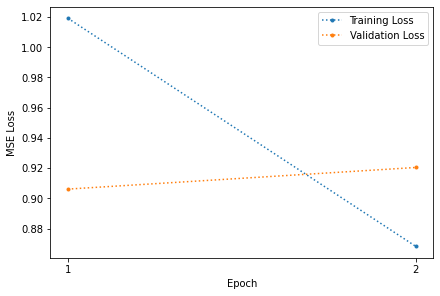

In [21]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
h = history.history
x = arange(len(h['loss'])) + 1
ax.plot(x, h['loss'], ':.', label='Training Loss')
ax.plot(x, h['val_loss'], ':.', label='Validation Loss')
ax.set_xticks(x)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend();

During training, the model was saved on the epoch with lowest validation loss. So we load that state back into the layers.

In [22]:
#reload model weights where the validation loss was minimized.
model.load_weights('./model-checkpoint');

Now we can compare the validation and test losses, which should be similar.

In [23]:
model.evaluate(validate);

225/225 [==============================] - 10s 21ms/step - loss: 0.9233 - mean_absolute_error: 0.7771


In [24]:
model.evaluate(test);

113/113 [==============================] - 8s 21ms/step - loss: 0.9387 - mean_absolute_error: 0.7824


Indeed, they're fine. They are not very low, but they're very similar.

# Results Inspection

In [25]:
#unpack the test inputs and targets
X, Y = zip(*test)
X = concatenate(X, axis=0).numpy()
Y = concatenate(Y).numpy()

In [26]:
#compute the predicted solar azimuth for the test set
Ypred = model.predict(X).flatten()

Here the targets and predictions are plotted against each other in histogram format. The red line shows the one-to-one line. If the model predicted perfectly, all of the predictions would exactly match the targets and the plot would collapse onto the red line.

Clearly, as we expect from the loss values, the model is not predicting effectively.
*   Toward the bottom left of the plot, low solar azimuth values are not well predicted. When the (standardized) targets are below zero, the predictions level off around 0.5. Low solar azimuth corresponds to situations with the sun almost directly above the observed surface. It's not suprising that the model fails to capture these targets. They should have almost no shadows.
*   Toward the top right of the plot, it looks like there is a group of images that the model has learned, somewhat, to correctly label. There is a vague tongue of results moving up with the red line. However, this is hardly discernable.

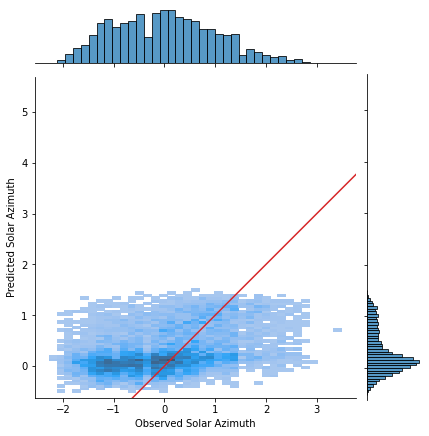

In [27]:
jp = seaborn.jointplot(x=Y, y=Ypred, kind='hist')
ax = jp.ax_joint
ax.set_xlabel('Observed Solar Azimuth')
ax.set_ylabel('Predicted Solar Azimuth')
ax.axis('square')
lims = (
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
)
ax.plot(lims, lims, 'C3');

In [28]:
r2_score(Y, Ypred)

0.0673967670335397

An intuitive metric for this target distribution (univariate continuous and roughly normal) is the coefficient of determination (r^2). As printed above, it's quite low. The model is only capturing a small fraction of the variation in solar azimuth.

In [29]:
#ordered mean absolute errors
mae = abs(Ypred - Y)

In [30]:
#images with accurate predictions and high solar azimuth
idxg = flatnonzero((Y >= 0.75) & (Ypred >= 0.75) & (mae < 0.05))

Below are 16 images with high solar azimuth, where the sun is closer to the horizon, that the model predicts accurately. Some of the images exhibit clear shadows that the model may be detecting, but many do not. We could speculate about which features might be detected, but because the model is poor, we know that even the accurate predictions are mostly random.

Further below, we also plot some examples of images with poorly predicted solar azimuth.

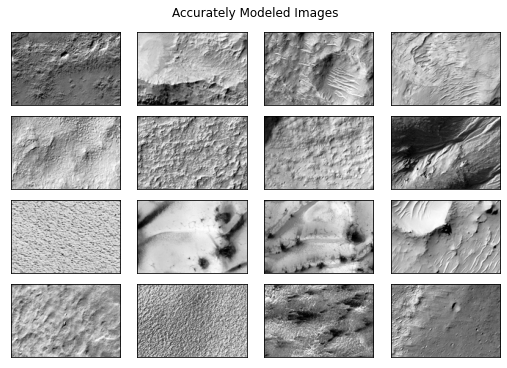

In [31]:
fig, axs = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow(X[idxg[i],...].squeeze(), cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Accurately Modeled Images');

In [32]:
#images with inaccurate predictions and high solar azimuth
idxb = flatnonzero((Y >= 0.75) & (Ypred >= 0.75) & (mae > 1))

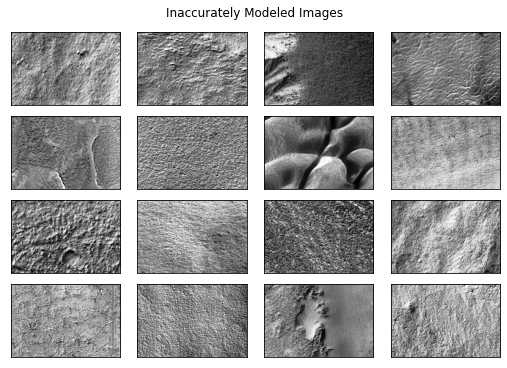

In [33]:
fig, axs = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow(X[idxb[i],...].squeeze(), cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Inaccurately Modeled Images');

In [34]:
#images with inaccurate predictions and low solar azimuth (sun directly overhead)
idxl = flatnonzero((Y <= -1) & (mae > 1))

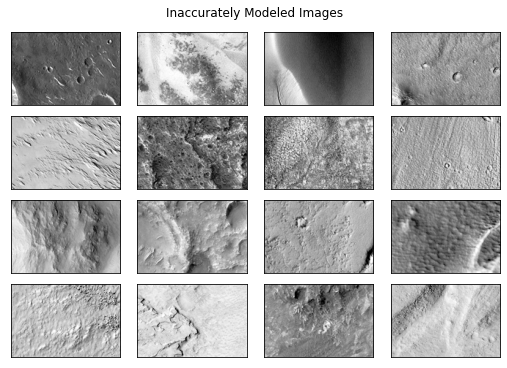

In [35]:
fig, axs = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow(X[idxl[i],...].squeeze(), cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Inaccurately Modeled Images');

# Deep Dreaming on Mars

I've always thought that reversing image models and asking them to dream up surreal and trippy patters is really cool. So I do some of it with these Martian surface images, just for fun. This time, I use the original color images.

In [36]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model

In [37]:
#reload images with color
images = np.load('drive/MyDrive/data/hirise-thumbnails/hirise_thumbnails.npy')
images.shape

(71968, 100, 150, 3)

In [38]:
iv3 = InceptionV3(include_top=False, weights='imagenet')

In [39]:
def dream_model(layer_numbers):
    layers = [iv3.get_layer('mixed'+str(n)).output for n in layer_numbers]
    dream = Model(inputs=iv3.input, outputs=layers)
    return dream

In [40]:
def dream_loss(image, model):
    batch = tf.expand_dims(image, axis=0)
    activations = model(batch)
    if len(activations) == 1:
        activations = [activations]
    losses = []
    for activation in activations:
        loss = tf.math.reduce_mean(activation)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [41]:
@tf.function
def dream_steps(image, steps, model, step_size=0.01):
    loss = tf.constant(0.0)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = dream_loss(image, model)
        grad = tape.gradient(loss, image)
        grad /= tf.math.reduce_std(grad) + 1e-8
        image = image + grad*step_size
        image = tf.clip_by_value(image, -1, 1)
    return image

In [42]:
def dream_frames(image_index, layer_numbers, steps=25):
    rescale = Rescaling(0.5, 0.5)
    dream = dream_model(layer_numbers)
    image = tf.keras.applications.inception_v3.preprocess_input(images[image_index,...])
    fig, axs = plt.subplots(3, 3, figsize=(9,6), constrained_layout=True)
    for ax in axs.flatten():
        ax.imshow(rescale(image))
        ax.set_xticks([])
        ax.set_yticks([])
        image = dream_steps(image, steps, dream)

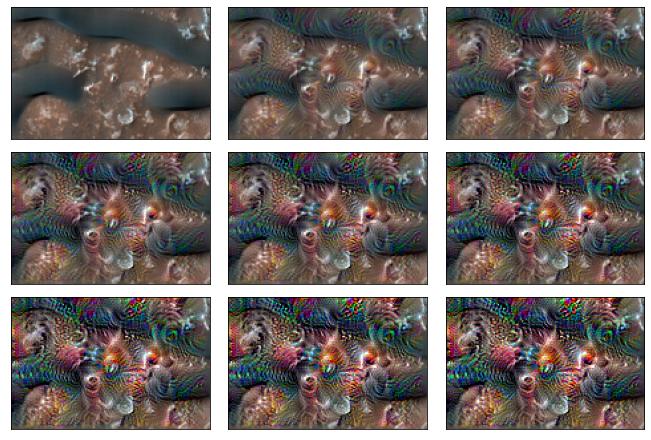

In [43]:
dream_frames(11, (2, 3))

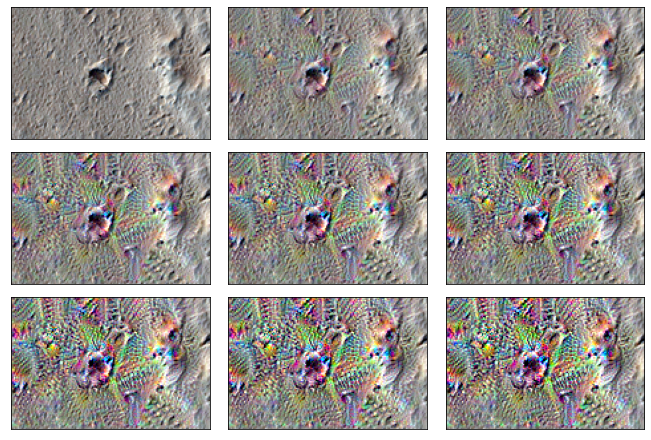

In [44]:
dream_frames(3, (3, 5))

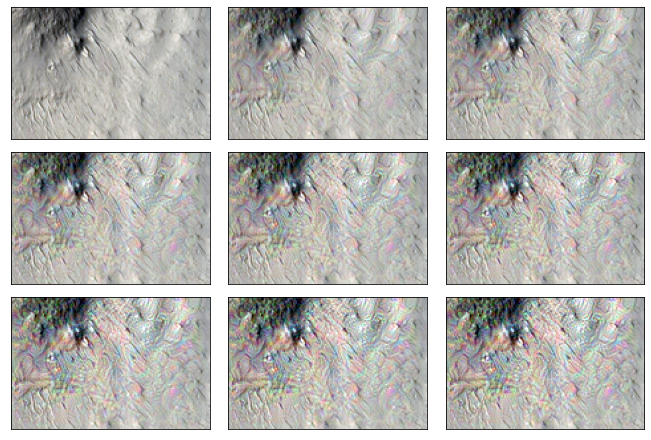

In [45]:
dream_frames(101, (7, 8))

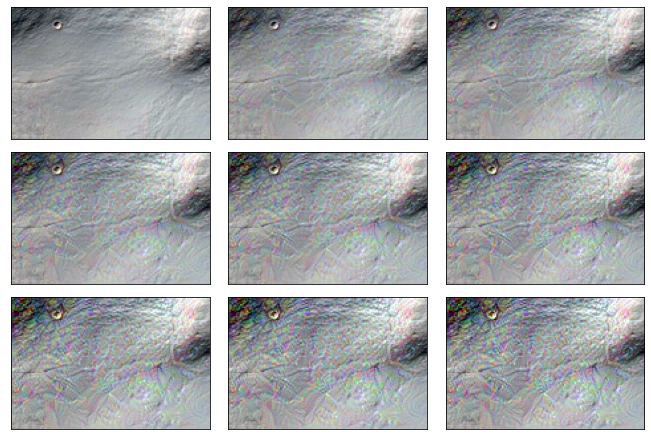

In [46]:
dream_frames(14, (10,))